# Varying GAN hyperparameters

We analyse results of experiments training real GANs (DCGAN) on CIFAR10 for various choices of the noise variance parameter $\sigma_z$ and $\kappa$.

Experiments are conducted outside the notebook using the `gan.py` script. 

In [127]:
from collections import defaultdict
import os
import pickle as pkl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [128]:
def summary(arr):
#     return np.mean(arr[-100:])
    return min(arr)
#     return arr[-1]


results_dir = "/work/jr19127/gan-loss-surfaces/vary_sigma_dcgan_cifar10"
results_dirs  = [os.path.join(results_dir, "results_{}".format(ind)) 
                 for ind in range(len(os.listdir(results_dir)))]
pkl_files = [os.path.join(rdir, x) for rdir in results_dirs for x in os.listdir(rdir) if x[-3:]==".pk"]

results = defaultdict(list)
for fn in pkl_files:
    with open(os.path.join(results_dir, fn), "rb") as fin:
        results[float(fn.split("/")[-1][:-3])].append(np.array(pkl.load(fin)))

sigmas = sorted(results.keys())

discrims = np.array([np.mean([summary(r[0]) for r in results[s]]) for s in sigmas])
discrims_std = np.array([np.std([summary(r[0]) for r in results[s]]) for s in sigmas])

gens = np.array([np.mean([summary(r[1]) for r in results[s]]) for s in sigmas])
gens_std = np.array([np.std([summary(r[1]) for r in results[s]]) for s in sigmas])

boths = np.array([np.mean([summary(r[0]+r[1]) for r in results[s]]) for s in sigmas])
boths_std = np.array([np.std([summary(r[0] + r[1]) for r in results[s]]) for s in sigmas])


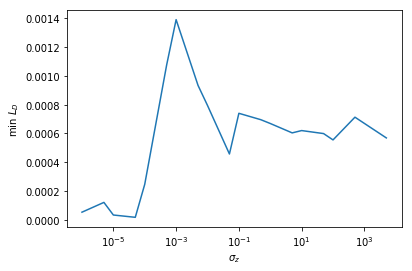

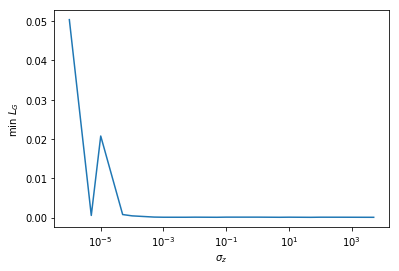

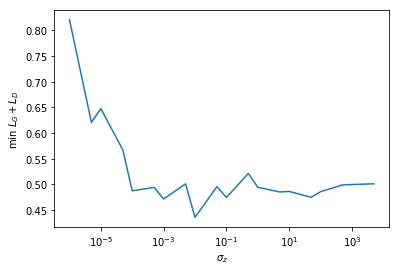

In [134]:
plt.plot(sigmas, discrims);
# plt.fill_between(sigmas, discrims-1.96*discrims_std, discrims+1.96*discrims_std, alpha=0.2);
plt.xlabel("$\sigma_z$");
plt.ylabel("min $L_D$");
plt.xscale('log')

onfrom = 0
plt.savefig("figures/ld_cifar10_gan.pdf")
plt.show();

plt.plot(sigmas[onfrom:], gens[onfrom:]);
# plt.fill_between(sigmas[onfrom:], gens[onfrom:]-1*gens_std[onfrom:], gens[onfrom:]+1*gens_std[onfrom:], 
#                  alpha=0.2);
plt.xlabel("$\sigma_z$");
plt.ylabel("min $L_G$");
plt.xscale('log')
plt.savefig("figures/lg_cifar10_gan.pdf")

plt.show();
plt.plot(sigmas, boths);
# plt.fill_between(sigmas, boths-1.96*boths_std, boths+1.96*boths_std, alpha=0.2);
plt.xlabel("$\sigma_z$");
plt.ylabel("min $L_G + L_D$");
plt.xscale('log')
plt.savefig("figures/ldlg_cifar10_gan.pdf")


In [125]:
discrims = pd.DataFrame(np.array([r[0] for r in results[10.]]).T).rolling(100).mean().values

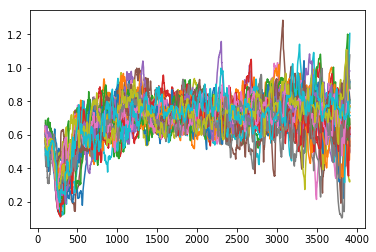

In [126]:
plt.plot(discrims);